In [ ]:
import numpy as np
import glob, keras, random, os, cv2, tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.python.client import device_lib
from keras.models import model_from_json
from tensorflow.keras import optimizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger('absl').setLevel(logging.ERROR)

# Fix random seed for reproducibility
def reproduct(s):
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tensorflow.random.set_seed(s)
    np.random.seed(s)
    random.seed(s)

# Get activation maps and these weigths
def get_F_and_A(img_array, model, last_conv_layer_name, pred_index=None):
    # Final convolution layer
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])

    # making F (activation maps)
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]
    F = np.array(last_conv_layer_output[0])

    # Making A (weights)
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))
    A = np.array(pooled_grads[..., tensorflow.newaxis])

    return F, A

# Making Grad-CAM
def make_grad_cam(F, A):

    # Sum A_k * F_k
    grad_cam = 0
    for k in range(F.shape[2]):
        grad_cam = grad_cam + F[:, :, k] * A[k]

    # ReLu (Sum_k [A_k * F_k] ): Removing negative effect
    for i in range(np.shape(F)[0]):
        for j in range(np.shape(F)[1]):
            if grad_cam[i, j] < 0:
                grad_cam[i, j] = 0

    return grad_cam

# making confusion matrix
def confusion_matrix(y_true, y_pred):
    count_true0_pred0 = 0
    count_true0_pred1 = 0
    count_true1_pred0 = 0
    count_true1_pred1 = 0

    for i in range(len(y_true)):
        # true: normal, prediction: normal
        if y_true[i] == 0 and y_pred[i] == 0:
            count_true0_pred0 = count_true0_pred0 + 1

        # true: normal, prediction: anomaly
        if y_true[i] == 0 and y_pred[i] == 1:
            count_true0_pred1 = count_true0_pred1 + 1

        # true: anomaly, prediction: normal
        if y_true[i] == 1 and y_pred[i] == 0:
            count_true1_pred0 = count_true1_pred0 + 1

        # true: anomaly, prediction: anomaly
        if y_true[i] == 1 and y_pred[i] == 1:
            count_true1_pred1 = count_true1_pred1 + 1

    print("Confusion Matrix: ")
    print("# True: normal & Prediction: normal:___", count_true0_pred0)
    print("# True: anomaly & Prediction: anomaly:_", count_true1_pred1)
    print("# True: normal & Prediction: anomaly:__", count_true0_pred1)
    print("# True: anomaly & Prediction: normal:__", count_true1_pred0)

In [ ]:
# making loadfile
!mkdir loadfile

# downloading "mikan.zip" and save it in "loadfile"
!wget -P loadfile http://int-info.com/PyLearn/metropolia/img_corn.zip

# Unzip "dat_meatball.zip" and save it in "loadfile"
!unzip -o -q loadfile/img_corn.zip -d loadfile

--2024-08-25 11:53:31--  http://int-info.com/PyLearn/metropolia/img_corn.zip
Resolving int-info.com (int-info.com)... 153.126.210.151
Connecting to int-info.com (int-info.com)|153.126.210.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5587729 (5.3M) [application/zip]
Saving to: ‘loadfile/img_corn.zip’

img_corn.zip        100%[===================>]   5.33M  3.63MB/s    in 1.5s    

2024-08-25 11:53:33 (3.63 MB/s) - ‘loadfile/img_corn.zip’ saved [5587729/5587729]



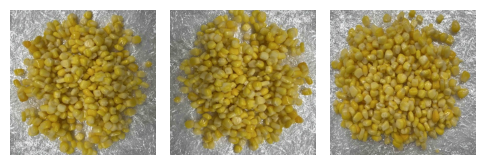

In [ ]:
# Loding
img_nor = np.zeros([40, 325, 325, 3]) # 40 images, height 325, width 325, RGB scale (3 channel)
fp = glob.glob("loadfile/img_corn/class_normal/*")
for i in range(len(fp)):
    img = cv2.imread(fp[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_nor[i] = img/255

# View 3 images
plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_nor[i])
    plt.axis('off')



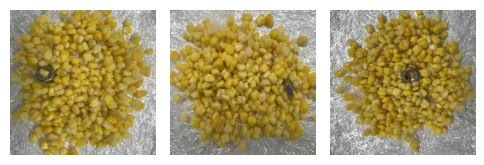

In [ ]:
# Loding
img_ano = np.zeros([40, 325, 325, 3]) # 40 images, height 325, width 325, RGB scale (3 channel)
fp = glob.glob("loadfile/img_corn/class_anomaly/*")
for i in range(len(fp)):
    img = cv2.imread(fp[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ano[i] = img/255

# View 3 images
plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ano[i])
    plt.axis('off')


In [ ]:
# making training data
size_train = 30
x_train_normal = img_nor[:size_train] # get normal 30 samples
x_train_anomaly = img_ano[:size_train] # get anomaly 30 samples
x_train = np.concatenate([x_train_normal, x_train_anomaly], axis = 0) # docking images
print("Shape of training images:", np.shape(x_train))

y_train_normal = np.zeros([size_train]) # class label for normal class (30 samples)
y_train_anomaly = np.ones([size_train]) # class label for anomaly class (30 samples)
y_train = np.concatenate([y_train_normal, y_train_anomaly]).astype("int") # docking labels
y_train = np.eye(np.max(y_train) + 1)[y_train] # one hot vector

Shape of training images: (60, 325, 325, 3)


In [ ]:
# making test data
x_test_normal = img_nor[size_train:] # get normal 20 samples
x_test_anomaly = img_ano[size_train:] # get anomaly 20 samples
x_test = np.concatenate([x_test_normal, x_test_anomaly], axis = 0) # docking images
print("Shape of test images:", np.shape(x_test))

y_test_nor = np.zeros([len(img_nor) - size_train]) # class label for normal class (100 - 80 = 20)
y_test_ano = np.ones([len(img_ano) - size_train]) # class label for anomaly class (100 - 80 = 20)
y_test = np.concatenate([y_test_nor, y_test_ano]).astype("int") # docking labels
y_test = np.eye(np.max(y_test) + 1)[y_test] # one hot vector

Shape of test images: (20, 325, 325, 3)


In [ ]:
# Fix the random seed for reproducibility (all members get same result)
reproduct(s=1)

# CNN layer architecture (corresponding to the above figure)
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5, 5), activation='relu', input_shape=np.shape(x_train[0])))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=5, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=5, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

# Training
eps = 250 # <- No. of parameters updating
model.compile(loss="mean_absolute_error", optimizer=optimizers.RMSprop(learning_rate=10**(-3)))
history = model.fit(x_train, y_train, batch_size=8, epochs=eps, verbose=1)

Epoch 1/250
8/8 [==============================] - 2s 139ms/step - loss: 0.5042
Epoch 2/250
8/8 [==============================] - 1s 136ms/step - loss: 0.5000
Epoch 3/250
8/8 [==============================] - 1s 132ms/step - loss: 0.5000
Epoch 4/250
8/8 [==============================] - 1s 132ms/step - loss: 0.5000
Epoch 5/250
8/8 [==============================] - 1s 138ms/step - loss: 0.5000
Epoch 6/250
8/8 [==============================] - 1s 133ms/step - loss: 0.5000
Epoch 7/250
8/8 [==============================] - 1s 132ms/step - loss: 0.5000
Epoch 8/250
8/8 [==============================] - 1s 130ms/step - loss: 0.5000
Epoch 9/250
8/8 [==============================] - 1s 129ms/step - loss: 0.5000
Epoch 10/250
8/8 [==============================] - 1s 131ms/step - loss: 0.5000
Epoch 11/250
8/8 [==============================] - 1s 129ms/step - loss: 0.5000
Epoch 12/250
8/8 [==============================] - 1s 131ms/step - loss: 0.5000
Epoch 13/250
8/8 [===================

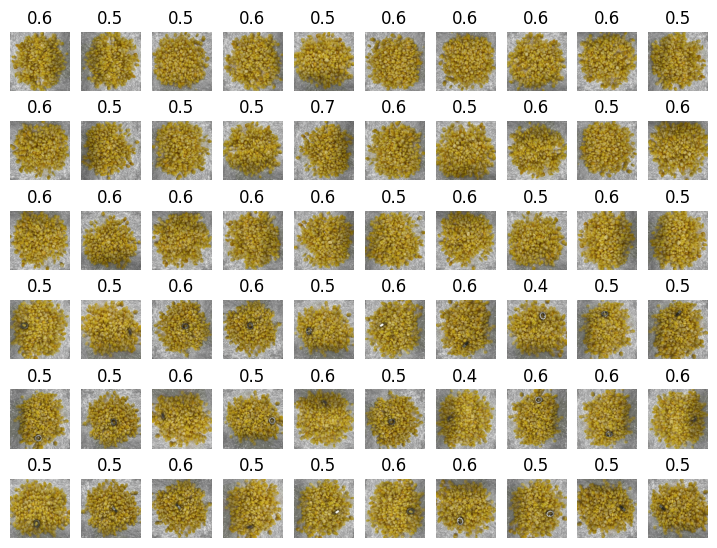

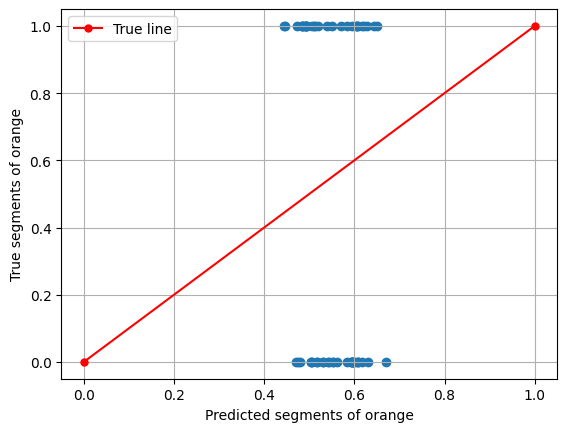

In [ ]:
y_train_pred = model.predict(x_train, verbose=0)

# each result
plt.figure(figsize=(9, 30))
for i in range(len(y_train)):
    plt.subplot(26, 10, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title(str(np.round(y_train_pred[i][0], 1)))
plt.show()

# scatter of true and prediction
plt.scatter(x=y_train_pred, y = y_train[:,1])
plt.plot([0,1], [0,1], color='red', marker="o", markersize=5, label="True line")
plt.grid()
plt.legend()
plt.ylabel("True segments of orange")
plt.xlabel("Predicted segments of orange")
plt.show()

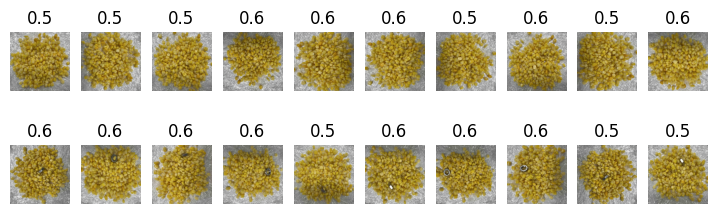

Text(0.5, 0, 'Predicted segments of orange')

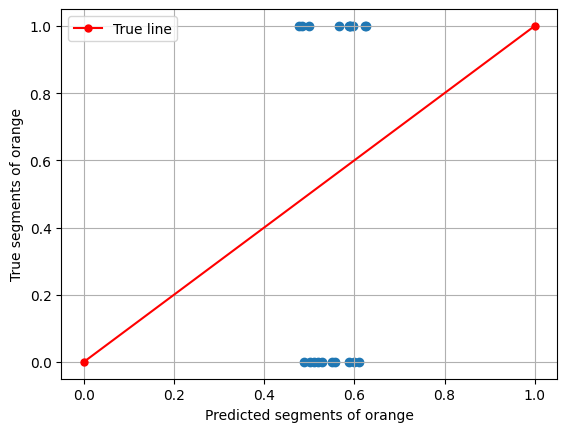

In [ ]:
y_test_pred = model.predict(x_test, verbose=0)

# each result
plt.figure(figsize=(9, 10))
for i in range(len(y_test)):
    plt.subplot(7, 10, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title(str(np.round(y_test_pred[i][0], 1)))
plt.show()

# scatter of true and prediction
plt.scatter(x=y_test_pred, y = y_test[:,1])
plt.plot([0,1], [0,1], color='red', marker="o", markersize=5, label="True line")
plt.grid()
plt.legend()
plt.ylabel("True segments of orange")
plt.xlabel("Predicted segments of orange")

In [ ]:
# Prediction
y_train_pred = model.predict(x_train, verbose=0)
y_test_pred = model.predict(x_test, verbose=0)

# Calculation of Mean Absolute Error
mae_train = mean_absolute_error(y_train_pred, y_train[:, 1])
mae_test = mean_absolute_error(y_test_pred, y_test[:, 1])

print("MAE of training data:_", np.round(mae_train, 2))
print("MAE of test data:___", np.round(mae_test, 2))

MAE of training data:_ 0.51
MAE of test data:___ 0.49


In [ ]:
from sklearn.metrics import confusion_matrix

# Define a threshold to convert probabilities to binary class labels
threshold = 0.5

# Convert continuous predictions to binary labels (0 or 1)
y_train_pred_labels = (y_train_pred > threshold).astype(int)
y_test_pred_labels = (y_test_pred > threshold).astype(int)

# Compute confusion matrix for training data
cm_train = confusion_matrix(y_train[:, 1], y_train_pred_labels)

# Compute confusion matrix for test data
cm_test = confusion_matrix(y_test[:, 1], y_test_pred_labels)

print("Confusion Matrix - Training Data:")
print(cm_train)

print("\nConfusion Matrix - Test Data:")
print(cm_test)

Confusion Matrix - Training Data:
[[ 3 27]
 [12 18]]

Confusion Matrix - Test Data:
[[1 9]
 [3 7]]


# Layer 0
# Size (321, 321, 5)


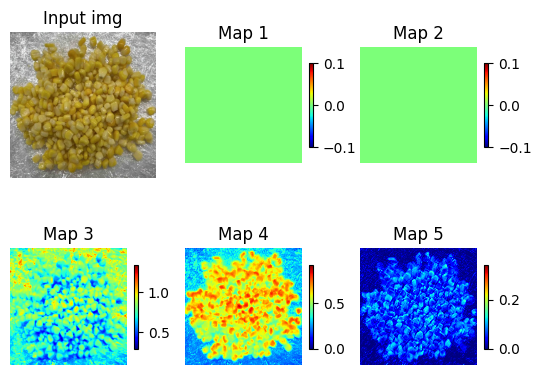

In [ ]:
test_img_id = 0
layer_number = 0

input_img = x_test[test_img_id:test_img_id+1]
layer_name = model.layers[layer_number].name
hidden_layer_model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

print("# Layer", layer_number)
f = hidden_layer_model.predict(input_img, verbose=0)
print("# Size", np.shape(f)[1:])

plt.subplot(2, 3, 1)
plt.imshow(input_img[0]), plt.axis('off')
plt.title("Input img")
for i in range(np.shape(f)[3]):
    plt.subplot(2, 3, i+2)
    plt.imshow(f[0, :, :, i], cmap="jet")
    plt.axis('off')
    plt.title("Map "+str(i+1))
    plt.colorbar(shrink=0.5)
plt.show()

# Weights
A1 = 0.0035093126
A2 = 0.004296212
A3 = 0.0026463864
A4 = 0.0035745546
A5 = 0.0042747706


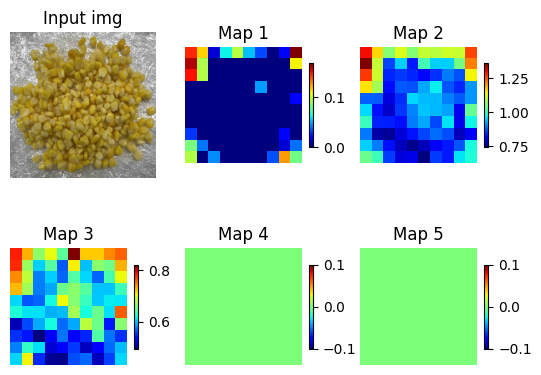

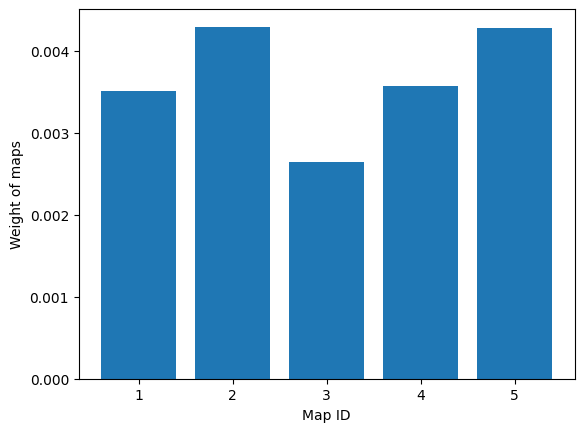

In [ ]:
img_id = 0

# input image
input_img = x_test[img_id:img_id+1]


lynm = model.layers[5].name # use layer 5
F, A = get_F_and_A(input_img, model, lynm)

# Show five maps of layer 5.
plt.subplot(2, 3, 1)
plt.imshow(input_img[0]), plt.axis('off')
plt.title("Input img")
print("# Weights")
for i in range(5):
    plt.subplot(2, 3, i+2)
    plt.imshow(F[:, :, i], cmap="jet")
    plt.axis('off')
    plt.title("Map "+str(i+1))
    plt.colorbar(shrink=0.5)
    print("A"+str(i+1)+" = "+str(A[i][0]))
plt.show()

# show five weights of five maps.
plt.bar(1+np.arange(len(A)), A[:, 0])
plt.ylabel("Weight of maps")
plt.xlabel("Map ID")
plt.show()

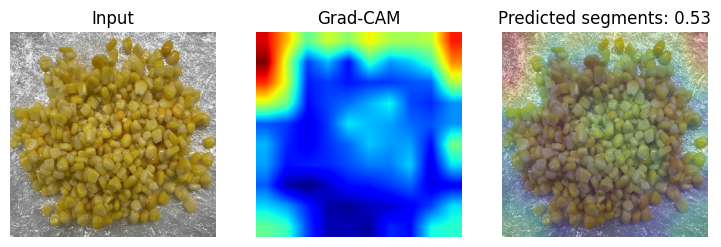

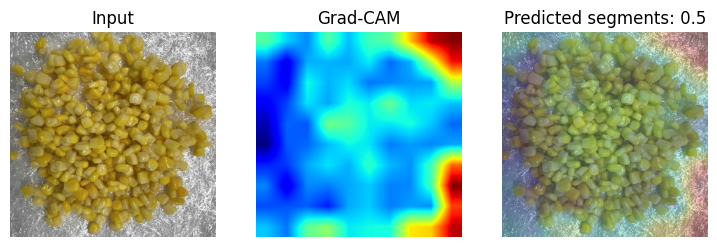

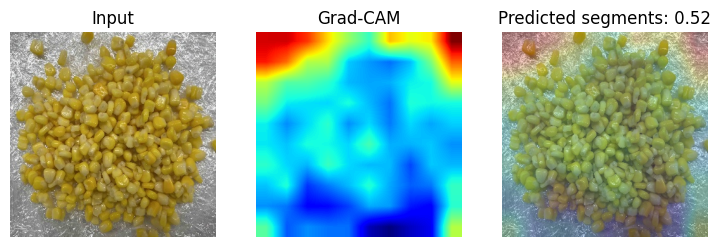

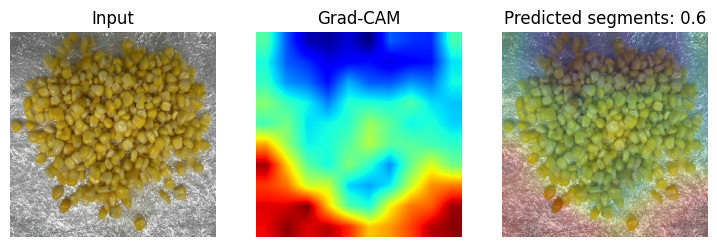

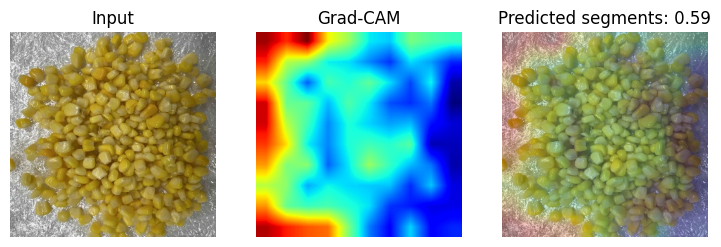

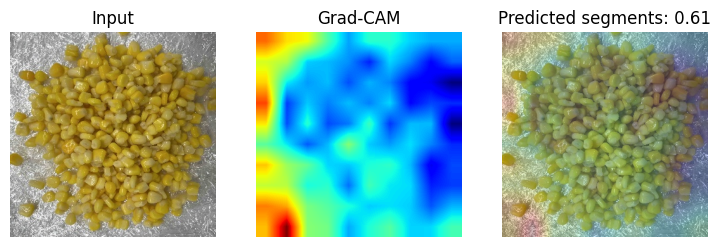

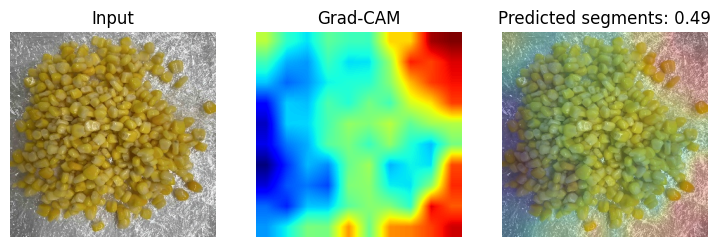

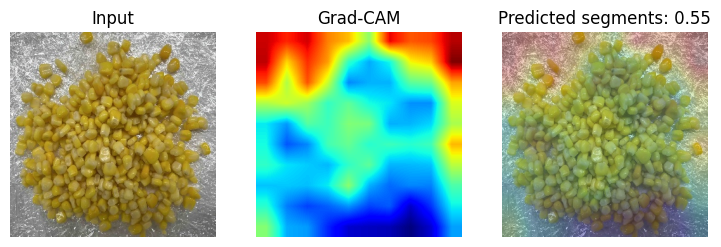

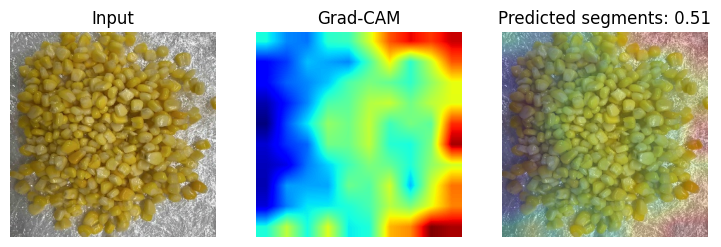

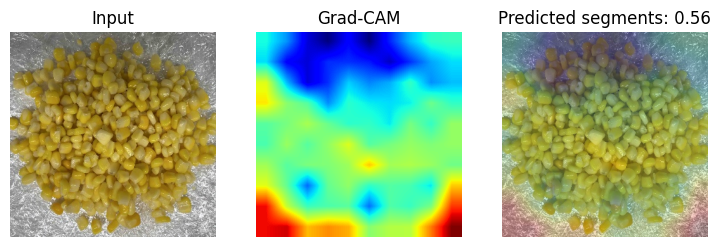

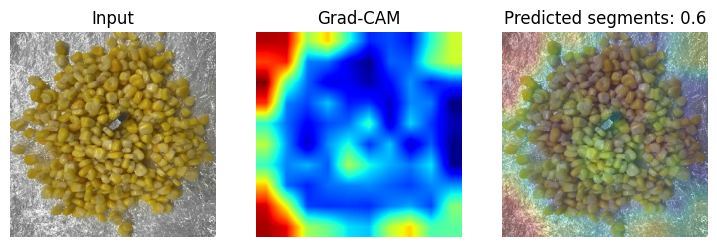

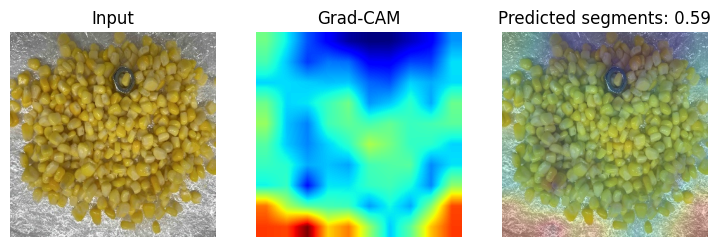

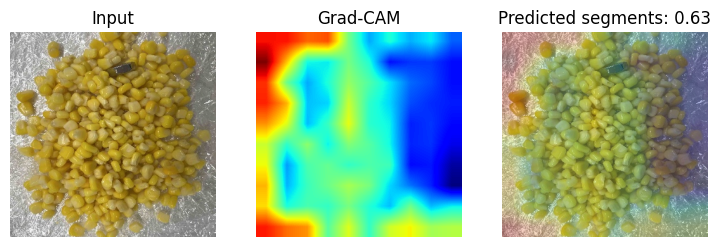

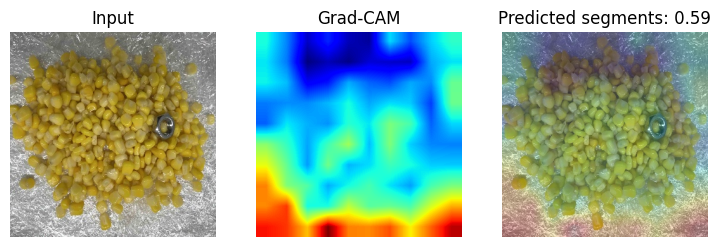

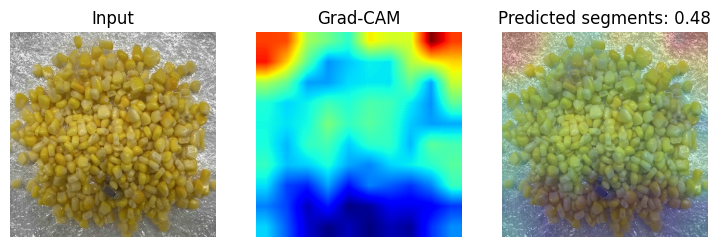

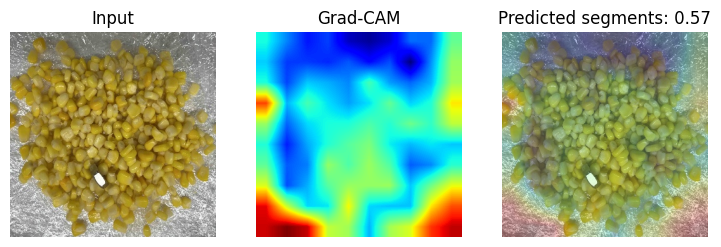

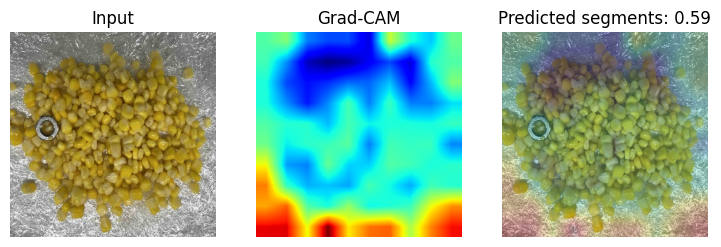

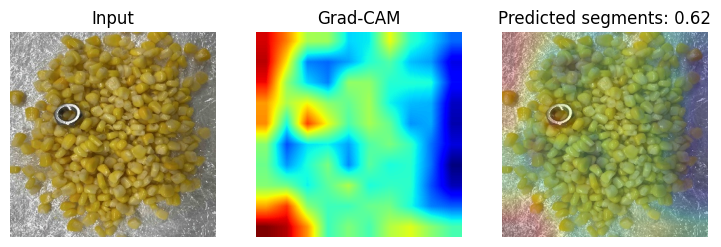

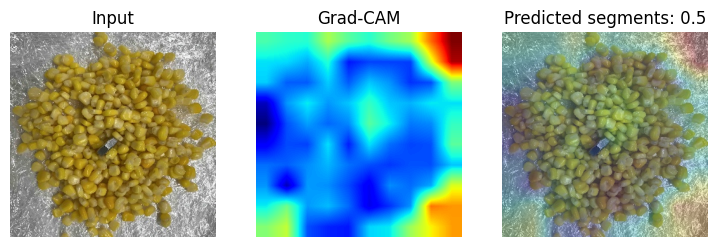

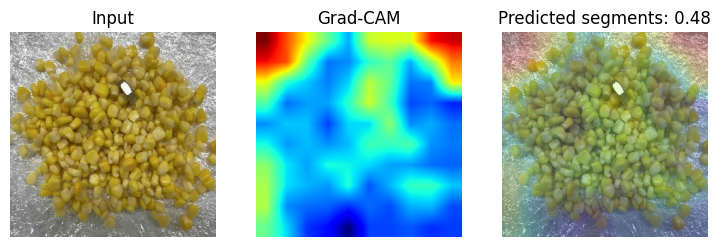

In [ ]:
for i in range(len(x_test)):
    pred = model.predict(x_test[i:i+1], verbose=0)[0][0]
    lynm = model.layers[5].name
    F, A = get_F_and_A(x_test[i:i+1], model, lynm) # func 1
    ram = make_grad_cam(F, A)
    ram = cv2.resize(ram, [325, 325])
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i])
    plt.title("Input")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(ram, cmap = "jet")
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(ram, cmap = "jet")
    plt.imshow(x_test[i], alpha = 0.8)
    plt.title("Predicted segments: "+str(np.round(pred, 2)))
    plt.axis("off")
    plt.show()